In [1]:
# Uncomment line below to install exlib
# !pip install exlib

In [2]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

import sys; sys.path.append("../../src")
import exlib
from exlib.datasets.chestx import *
from exlib.features.vision import *

/home/antonxue/lib/miniconda3/envs/exlib/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Overview
* The objective is to predict the **pathology** regions (atelectasis, calcification, etc. Total 13).
* The higher-level features are the anatomical **structures** (left clavicle, right clavicle, etc. Total 14).

In [3]:
dataset = ChestXDataset(split="test")

## Dataset samples
Primary task: predict where the pathologies are

In [4]:
torch.manual_seed(105)
for i in torch.randperm(len(dataset)):
    sample = dataset[i.item()]
    image, pathols, structs = sample["image"], sample["pathols"], sample["structs"]
    if pathols.sum() > 2 and structs.sum() > 0:
        break

Pathologies present:
Atelectasis
Consolidation
Effusion


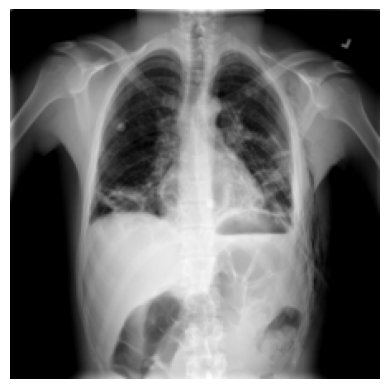

In [5]:
plt.clf()
plt.imshow(image.numpy().transpose(1,2,0), cmap="gray")
plt.axis("off")

print("Pathologies present:")
for idx in pathols.nonzero():
    print(dataset.pathology_names[idx.item()])

## Expert-specified higher-level features: anatomical structures
Identifying where key structures are is important!

<Figure size 640x480 with 0 Axes>

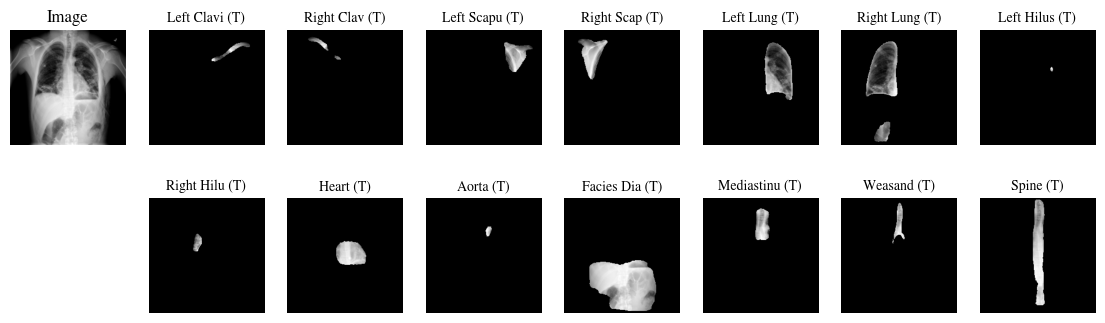

In [6]:
plt.clf()
fig, ax = plt.subplot_mosaic([
    (["image"] + [f"struct{i}t" for i in range(7)]),
    (["."] + [f"struct{i}t" for i in range(7,14)]),
], figsize=(14,4))

for _, a in ax.items(): a.set_axis_off()
struct_titles = ChestXDataset.structure_names

ax["image"].imshow(image.numpy().transpose(1,2,0), cmap="gray")
ax["image"].set_title("Image")

for i in range(14):
    mask_t = structs[i].unsqueeze(0)
    ax[f"struct{i}t"].imshow(((image * mask_t).numpy().transpose(1,2,0)) * 2, cmap="gray")
    ax[f"struct{i}t"].set_title(f"{struct_titles[i][:10]} (T)", fontsize=10)

## How well are the higher-level feature alignments?

In [7]:
all_baseline_scores = get_chestx_scores(num_todo=100, batch_size=8)

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [09:42<00:00, 44.80s/it]


In [8]:
for name, scores in all_baseline_scores.items():
    print(f'BASELINE {name} mean score: {scores.mean()}')

BASELINE identity mean score: 0.21211296319961548
BASELINE random mean score: 0.04255373775959015
BASELINE patch mean score: 0.09955804795026779
BASELINE quickshift mean score: 0.3367842137813568
BASELINE watershed mean score: 0.14116907119750977
BASELINE sam mean score: 0.30522453784942627
BASELINE ace mean score: 0.2596263885498047
BASELINE craft mean score: 0.11851011216640472
BASELINE archipelago mean score: 0.2134942263364792
